In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join("..", "..")))

# Chicago data

Now with no Gaussian decay

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sepp.sepp_grid
import sepp.sepp_grid_space
import open_cp.logger
open_cp.logger.log_to_true_stdout("sepp")

In [3]:
import open_cp.sources.chicago
import open_cp.geometry
import descartes
import pickle, lzma, datetime
import open_cp.predictors
import open_cp.kernels

In [4]:
datadir = os.path.join("..", "..", "..", "..", "..", "Data")
#datadir = os.path.join("/media", "disk", "Data")
open_cp.sources.chicago.set_data_directory(datadir)

with lzma.open(os.path.join(datadir, "chicago_all.csv.xz"), "rt") as file:
    all_points = open_cp.sources.chicago.load(file, "BURGLARY", type="all")

In [5]:
northside = open_cp.sources.chicago.get_side("North")
grid = open_cp.data.Grid(150, 150, 0, 0)
grid = open_cp.geometry.mask_grid_by_intersection(northside, grid)

In [6]:
mask = (all_points.timestamps >= np.datetime64("2016-01-01")) & (all_points.timestamps < np.datetime64("2017-01-01"))
points = all_points[mask]
points = open_cp.geometry.intersect_timed_points(points, northside)

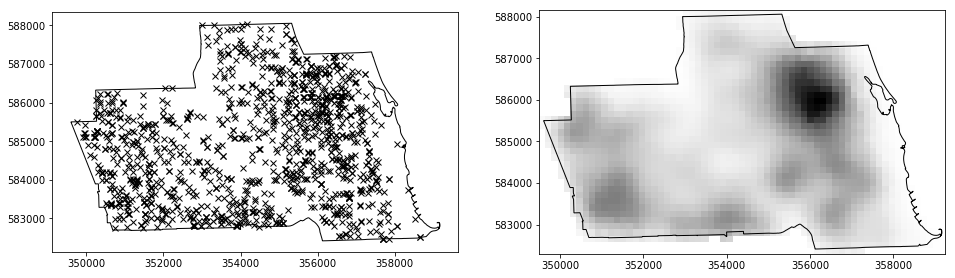

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(16,10))

ax = axes[0]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
ax.scatter(points.xcoords, points.ycoords, marker="x", color="black", linewidth=1)

kernel = open_cp.kernels.GaussianBase(points.coords)
kernel.bandwidth = 300
kernel.covariance_matrix = [[1,0], [0,1]]
_pred = open_cp.predictors.grid_prediction_from_kernel_and_masked_grid(kernel, grid, samples=5)
ax = axes[1]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
ax.pcolor(*_pred.mesh_data(), _pred.intensity_matrix, cmap="Greys", rasterized=True)
None

## Train

In [8]:
trainer = sepp.sepp_grid_space.Trainer2(grid, 20)
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
model

Model2(mu size=(39, 65), T=365.9583333333333, grid=RectangularRegion( (349500,582300) -> (359250,588150) ), theta=0.24536963563308467, omega=0.00849198646521841, r0=20

In [9]:
predictor = trainer.to_predictor(model)
predictor.data = trainer.data
pred1 = predictor.predict(datetime.datetime(2017,1,1))
pred2 = predictor.predict(datetime.datetime(2016,9,1))
pred3 = predictor.predict(datetime.datetime(2016,10,15))

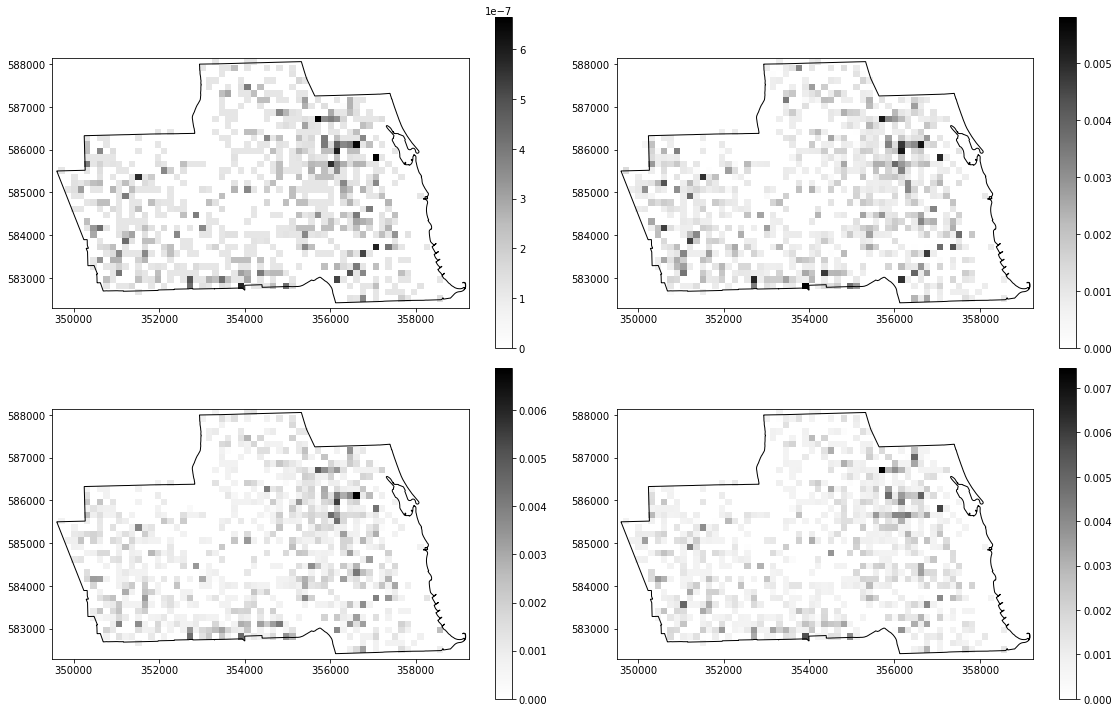

In [10]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16,10))

for ax in axes.flat:
    ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
    ax.set_aspect(1)

bpred = open_cp.predictors.GridPredictionArray(grid.xsize, grid.ysize, model.mu, grid.xoffset, grid.yoffset)

for ax, pred in zip(axes.flat, [bpred, pred1, pred2, pred3]):
    m = ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
    cb = fig.colorbar(m, ax=ax)
fig.tight_layout()

# How it changes with $r_0$

In [11]:
r0_range = np.exp(np.linspace(0, np.log(200), 100))
models = {}
for r0 in r0_range:
    trainer = sepp.sepp_grid_space.Trainer2(grid, r0)
    trainer.data = points
    models[r0] = trainer.train(datetime.datetime(2017,1,1), iterations=50)

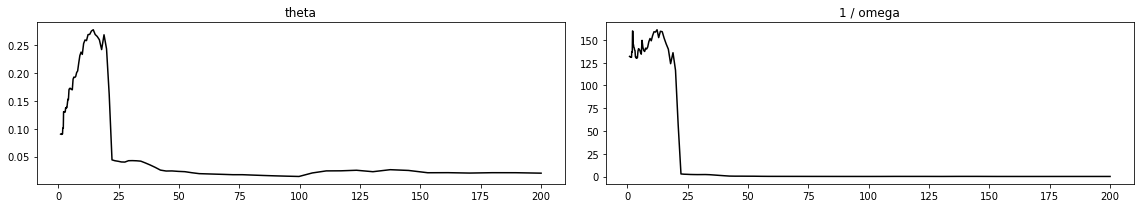

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(16,3))

axes[0].plot(r0_range, [models[r].theta for r in r0_range], color="black")
axes[0].set(title="theta")
axes[1].plot(r0_range, [1/models[r].omega for r in r0_range], color="black")
axes[1].set(title="1 / omega")

fig.tight_layout()
fig.savefig("../varying_r0_no_g.pdf")

# Fix everything

In [13]:
trainer = sepp.sepp_grid_space.Trainer2(grid, 300)
trainer.data = points

In [14]:
T, data = trainer.make_data()
model = trainer.initial_model(T, data)
model

Model2(mu size=(39, 65), T=365.9583333333333, grid=RectangularRegion( (349500,582300) -> (359250,588150) ), theta=0.5, omega=1, r0=300

In [15]:
for _ in range(50):
    model = sepp.sepp_grid_space.Model2(model.mu, model.T, model.grid, model.theta, 1/20, model.r0)
    opt = trainer._optimiser(model, data)
    model = opt.iterate()

In [16]:
model

Model2(mu size=(39, 65), T=365.9583333333333, grid=RectangularRegion( (349500,582300) -> (359250,588150) ), theta=6.79415517169123e-12, omega=0.052218995471067585, r0=300

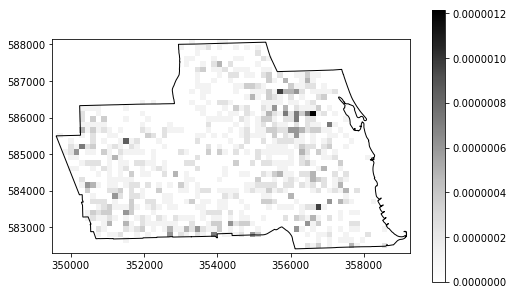

In [17]:
bpred = open_cp.predictors.GridPredictionArray(grid.xsize, grid.ysize, model.mu, grid.xoffset, grid.yoffset)
fig, ax = plt.subplots(figsize=(8,5))
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
m = ax.pcolor(*bpred.mesh_data(), bpred.intensity_matrix, cmap="Greys", rasterized=True)
cb = fig.colorbar(m, ax=ax)

Look at $L = \sum_j \log(b_j + \theta t_j) - n\theta$ so
$$ \frac{\delta}{\delta \theta} L =
\sum_j \frac{t_j}{b_j + \theta t_j} - n
= \sum_j \frac{1}{(t_j/b_j)^{-1} + \theta} - n $$

So I think that we get a very negative number means that $\theta=0$ is the optimal.

In [18]:
backs = model.background(data)

In [19]:
trigs = [0]
for j in range(1, data.shape[-1]):
    deltas = data[:,j][:,None] - data[:,:j]
    trigs.append( np.sum(model.trigger(None, deltas)) )
trigs = np.asarray(trigs) / model.theta

In [20]:
np.sum(trigs / backs) - len(backs)

-506.03330255081914

In [21]:
model.omega * np.exp(-model.omega) / (np.pi * model.r0**2)

1.7529022940286143e-07

Force $\theta=0.4$ says...

In [22]:
T, data = trainer.make_data()
model = trainer.initial_model(T, data)
for _ in range(150):
    model = sepp.sepp_grid_space.Model2(model.mu, model.T, model.grid, 0.4, 1/20, model.r0)
    opt = trainer._optimiser(model, data)
    model = opt.iterate()
model

Model2(mu size=(39, 65), T=365.9583333333333, grid=RectangularRegion( (349500,582300) -> (359250,588150) ), theta=0.22465959159780102, omega=0.05023274860410931, r0=300

In [23]:
backs = model.background(data)
trigs = [0]
for j in range(1, data.shape[-1]):
    deltas = data[:,j][:,None] - data[:,:j]
    trigs.append( np.sum(model.trigger(None, deltas)) )
trigs = np.asarray(trigs) / model.theta

np.sum(trigs / backs) - len(backs)

2.0412742335936194e+61

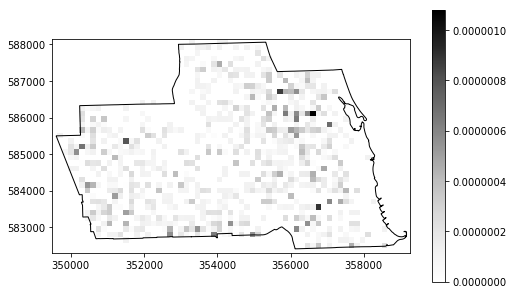

In [24]:
bpred = open_cp.predictors.GridPredictionArray(grid.xsize, grid.ysize, model.mu, grid.xoffset, grid.yoffset)
fig, ax = plt.subplots(figsize=(8,5))
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
m = ax.pcolor(*bpred.mesh_data(), bpred.intensity_matrix, cmap="Greys", rasterized=True)
cb = fig.colorbar(m, ax=ax)

In [25]:
w = trigs / backs
w = w[w>0]
def f(theta):
    return np.sum(1/(1/w + theta)) - len(trigs)
f(0), f(0.01), f(0.1), f(0.2)

(2.0412742335936191e+61,
 3631.8367776751402,
 13.481768456674217,
 -319.83764709849277)

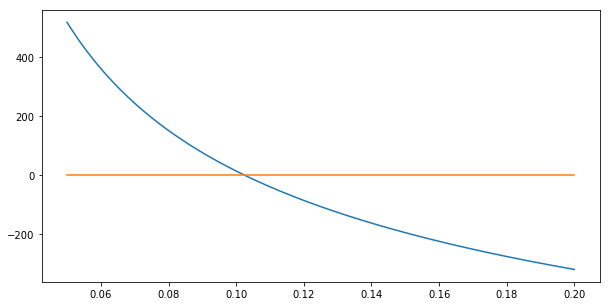

In [26]:
theta = np.linspace(0.05, 0.2, 200)
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(theta, [f(t) for t in theta])
ax.plot(theta, [0]*len(theta))